In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 100
ens_size = int(1e4)
ens_ens_size = 10
variances = np.linspace(10, 1, dimension)
ensemble_array = (np.sqrt(variances)[:, None, None]
                  * np.random.randn(dimension, ens_size, ens_ens_size))
H = np.eye(dimension)[::2]
obs_size = H.shape[0]

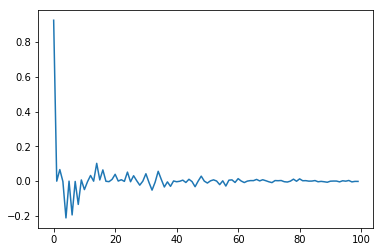

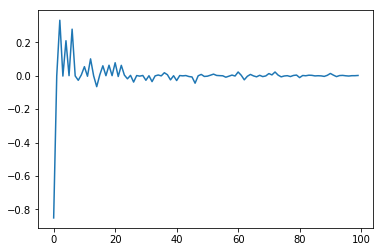

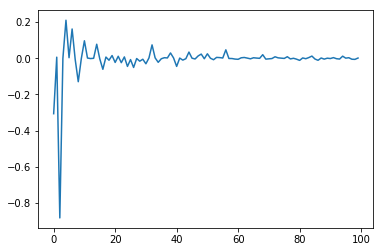

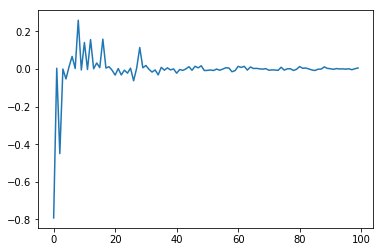

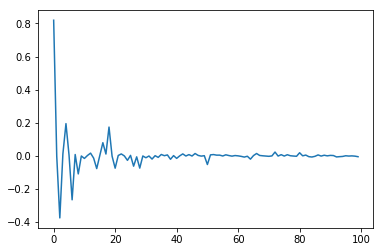

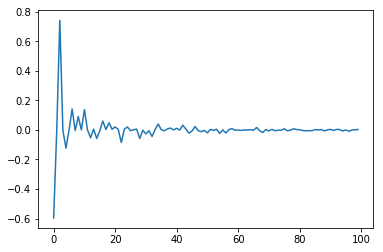

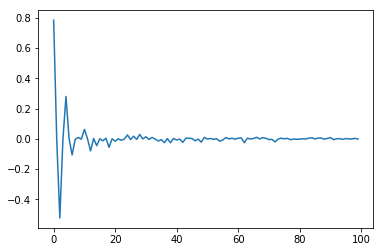

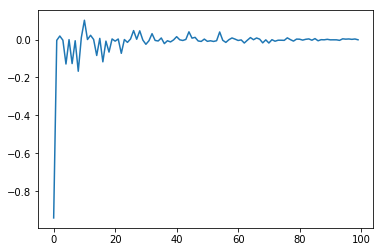

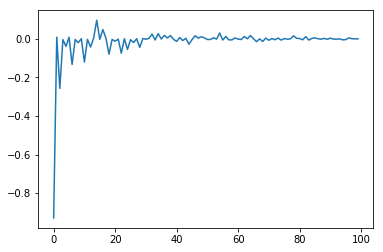

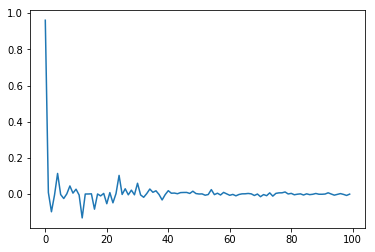

In [6]:
P_sample_array = np.ones(
    [dimension, dimension, ens_ens_size]) * np.nan
S_sample_array = np.ones(
    [obs_size, dimension, ens_ens_size]) * np.nan
VT_sample_array = np.ones(
    [dimension, dimension, ens_ens_size]) * np.nan
U_sample_array = np.ones(
    [obs_size, obs_size, ens_ens_size]) * np.nan
for ii in range(ens_ens_size):
    P_sample_array[:, :, ii] = np.cov(
        ensemble_array[:, :, ii])
    trans_mats = assimilate.transformation_matrices(
        H=H, P=P_sample_array[:, :, ii], R=np.eye(obs_size))
    aU = trans_mats['U']
    aS = trans_mats['S']
    aVT = trans_mats['VT']
    U_sample_array[:, :, ii] = aU
    S_sample_array[:, :, ii] = aS
    VT_sample_array[:, :, ii] = aVT
    
    plt.figure()
    plt.plot(aVT[0])

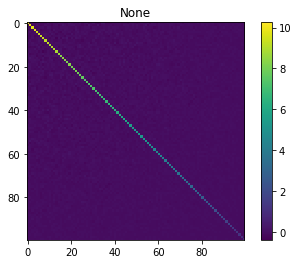

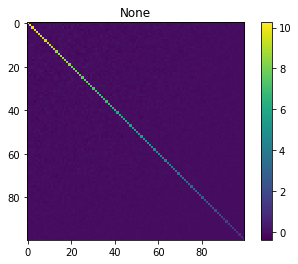

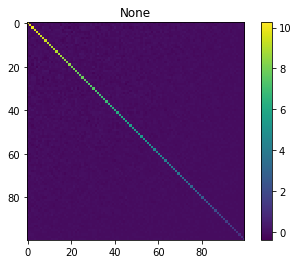

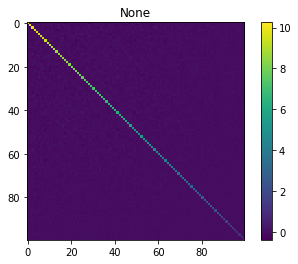

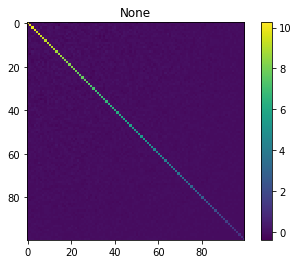

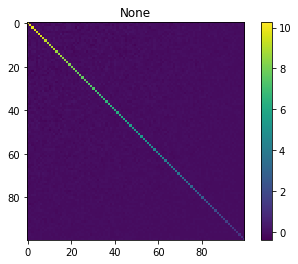

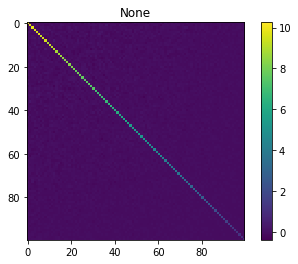

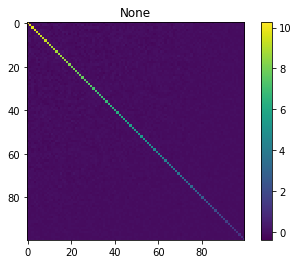

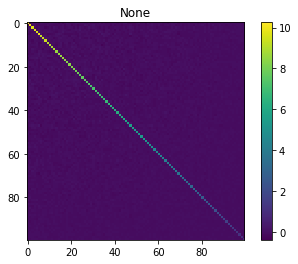

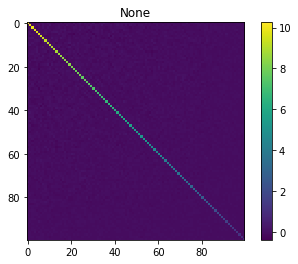

In [7]:
vmin = P_sample_array.min()
vmax = P_sample_array.max()
for ii in range(ens_ens_size):
    imshow(P_sample_array[:, :, ii], vmin=vmin, vmax=vmax)

In [8]:
# Sensitivity to 

In [30]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# dx = 0.25
dx = 1/dimension

obs_size = int(dimension/2)
H = assimilate.random_H(dimension, obs_size)

# H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [31]:
eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_sqd_exp_1d,
    return_Corr=True,
    return_sort_ind=True)
eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
# sort_ind = np.argsort(sort_ind)
# eig_val = eig_val[sort_ind]
# eig_vec = eig_vec[:, sort_ind]
# eig_val = np.fft.fftshift(eig_val)
# eig_vec = np.fft.fftshift(eig_vec, axes=1)

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(obs_size)

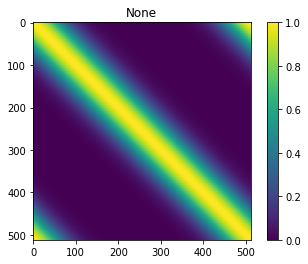

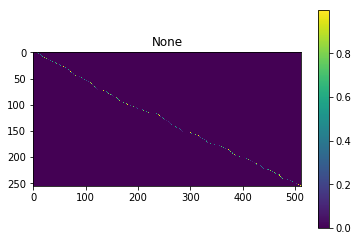

In [32]:
imshow(P, vmin=0)
imshow(H)

In [60]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    exec(key + '=val')

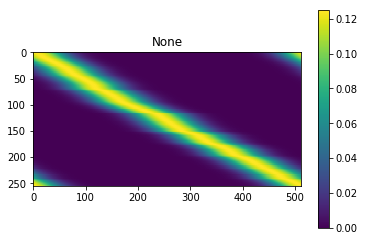

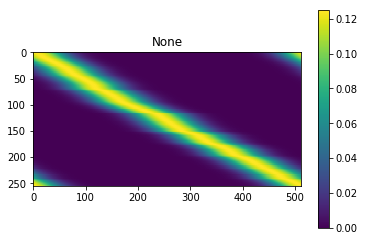

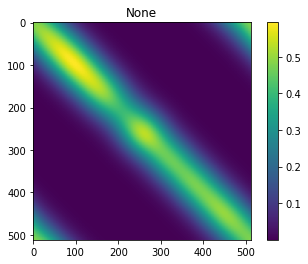

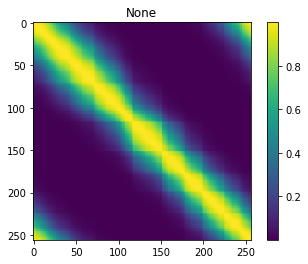

In [61]:
imshow(U @ S @ VT)
imshow(H @ P_sqrt)

imshow((H @ P_sqrt).T @ (H @ P_sqrt))

imshow((H @ P_sqrt) @ (H @ P_sqrt).T)

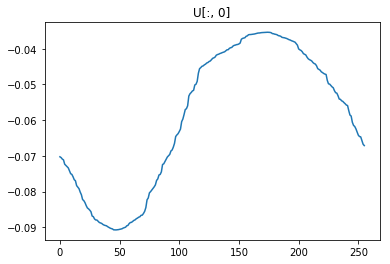

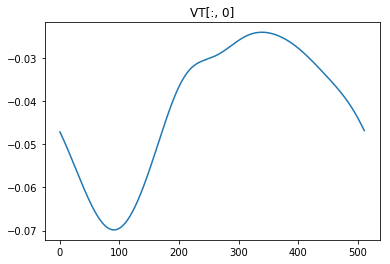

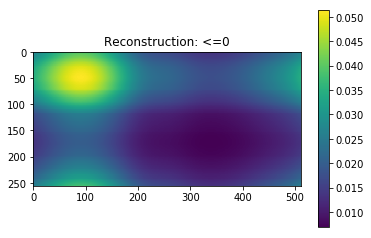

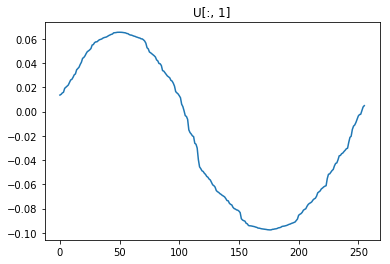

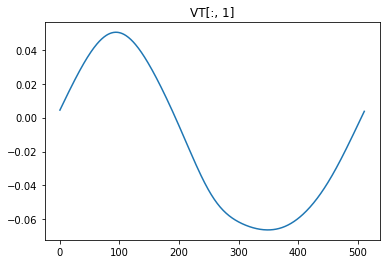

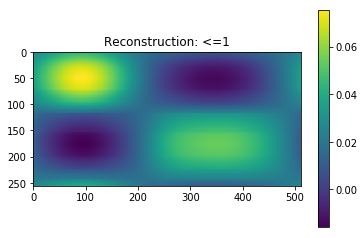

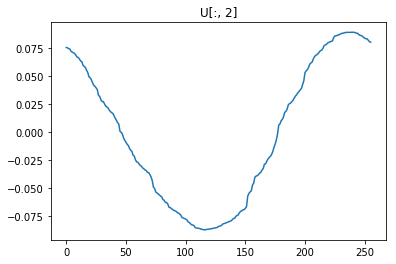

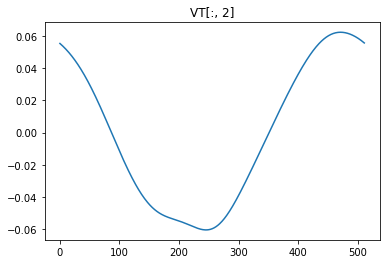

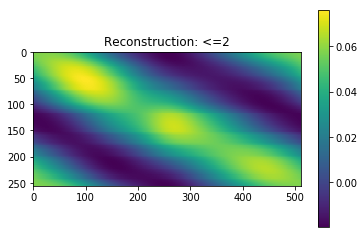

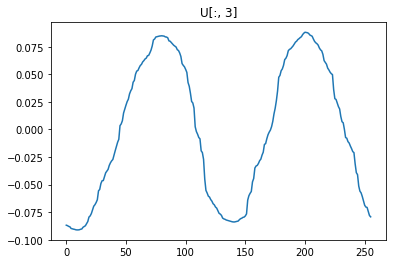

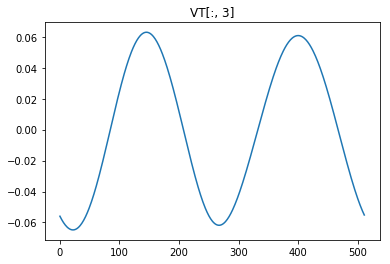

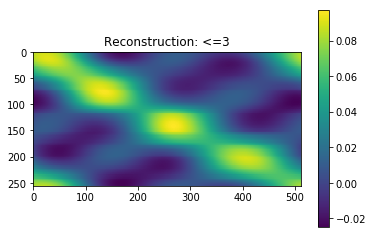

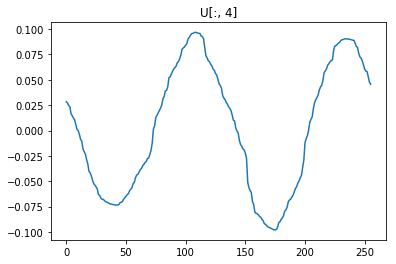

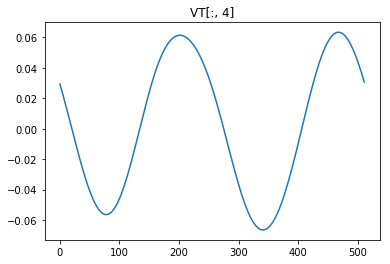

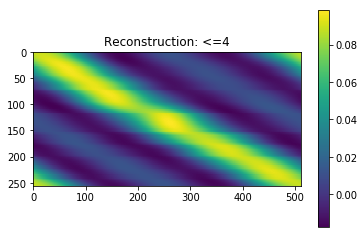

In [62]:
prev = np.zeros_like(S)
number = 5
for ii in range(number):
    plt.figure()
    plt.plot(U[:, ii])
    plt.title(f'U[:, {ii}]')
    
    plt.figure()
    plt.plot(VT[ii])
    plt.title(f'VT[:, {ii}]')
    
    prev += (S.diagonal()[ii]
             * U[:, ii:ii+1]
             @ VT[ii:ii + 1])
    
    imshow(prev, f'Reconstruction: <={ii}')

In [95]:
def angle_2(V0, V1):
    norm0 = sp.linalg.norm(V0, ord=2, axis=0)
    norm1 = sp.linalg.norm(V1, ord=2, axis=0)
    V0 = V0/norm0
    V1 = V1/norm1
    IPs = V0.T @ V1
    sigmas = sp.linalg.svd(
        IPs,
        compute_uv=False)
    dist = np.arccos(sigmas)
    dist = dist.mean()
    return dist

def angle(V0, V1):
    IPs = V0.T @ V1
    norm0 = (V0 ** 2).sum(axis=0)
    norm1 = (V1 ** 2).sum(axis=0)
    norm0 = norm0[:, None]
    norm1 = norm1[None, :]
    sigmas = sp.linalg.svd(
        IPs / np.sqrt(norm0 * norm1),
        compute_uv=False)
    dist = np.arccos(sigmas.min())
    return dist

In [96]:
sig_num = 1
iter_num = 10
V_true = VT[:sig_num].T
mu = np.zeros(dimension)
ens_array = np.arange(50, 2050, 200)
angle_array = ens_array * np.nan
for count, ens_size in enumerate(ens_array):
    dist = np.ones(iter_num) * np.nan
    for num in range(iter_num):
        ensemble = assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt'])
        P_sample = np.cov(ensemble)
        this_trans_mats = assimilate.transformation_matrices(
            H, P=P_sample,
            R=R, return_Ts=False)
        this_V = this_trans_mats['VT'][:sig_num].T
        dist[num] = angle(V_true, this_V)
    angle_array[count] = dist.mean()
    print(f'ens_size: {ens_size} ; angle: {angle_array[count]}')

ens_size: 50 ; angle: 0.9081456870772271
ens_size: 250 ; angle: 0.35600828923961064
ens_size: 450 ; angle: 0.28963235992114367
ens_size: 650 ; angle: 0.2509570567030723
ens_size: 850 ; angle: 0.2565645991061647
ens_size: 1050 ; angle: 0.22352689022851338
ens_size: 1250 ; angle: 0.19125075787777399
ens_size: 1450 ; angle: 0.17078065130543102
ens_size: 1650 ; angle: 0.11912204434324632
ens_size: 1850 ; angle: 0.14623707465950417


Text(0.5,1,'Angle for sig_num: 1')

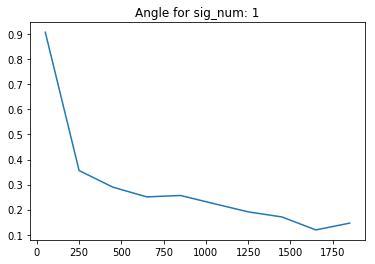

In [97]:
plt.figure()
plt.plot(ens_array, angle_array)
plt.title(f'Angle for sig_num: {sig_num}')

In [98]:
sig_num = 3
V_true = VT[:sig_num].T
mu = np.zeros(dimension)
angle_array2 = ens_array * np.nan
for count, ens_size in enumerate(ens_array):
    dist = np.ones(iter_num) * np.nan
    for num in range(iter_num):
        ensemble = assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt'])
        P_sample = np.cov(ensemble)
        this_trans_mats = assimilate.transformation_matrices(
            H, P=P_sample,
            R=R, return_Ts=False)
        this_V = this_trans_mats['VT'][:sig_num].T
        dist[num] = angle(V_true, this_V)
    angle_array2[count] = dist.mean()
    print(f'ens_size: {ens_size} ; angle: {angle_array2[count]}')

ens_size: 50 ; angle: 0.6020788261199701
ens_size: 250 ; angle: 0.2477626604647905
ens_size: 450 ; angle: 0.17387828490221408
ens_size: 650 ; angle: 0.14295254896325782
ens_size: 850 ; angle: 0.12286186682534173
ens_size: 1050 ; angle: 0.09492134865992295
ens_size: 1250 ; angle: 0.11322152176997338
ens_size: 1450 ; angle: 0.09216728014938094
ens_size: 1650 ; angle: 0.0954964512286966
ens_size: 1850 ; angle: 0.08613871034975848


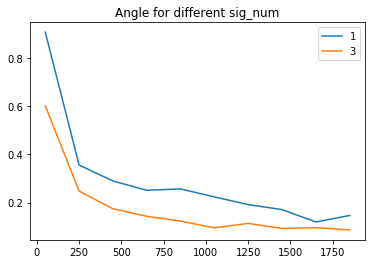

In [99]:
plt.figure()
plt.plot(ens_array, angle_array)
plt.plot(ens_array, angle_array2)
plt.title(f'Angle for different sig_num')
plt.legend(['1', '3'])

In [90]:
sig_num = 5
V_true = VT[:sig_num].T
mu = np.zeros(dimension)
angle_array3 = ens_array * np.nan
for count, ens_size in enumerate(ens_array):
    dist = np.ones(iter_num) * np.nan
    for num in range(iter_num):
        ensemble = assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt'])
        P_sample = np.cov(ensemble)
        this_trans_mats = assimilate.transformation_matrices(
            H, P=P_sample,
            R=R, return_Ts=False)
        this_V = this_trans_mats['VT'][:sig_num].T
        dist[num] = angle(V_true, this_V)
    angle_array3[count] = dist.mean()
    print(f'ens_size: {ens_size} ; angle: {angle_array3[count]}')

ens_size: 50 ; angle: 0.8725714519462613
ens_size: 250 ; angle: 0.469163220839528
ens_size: 450 ; angle: 0.3487877552693479
ens_size: 650 ; angle: 0.22098103935973246
ens_size: 850 ; angle: 0.21193594519113956
ens_size: 1050 ; angle: 0.20464788462667224
ens_size: 1250 ; angle: 0.16957080179846445
ens_size: 1450 ; angle: 0.1549445460709154
ens_size: 1650 ; angle: 0.13454379551673185
ens_size: 1850 ; angle: 0.13082664455287296


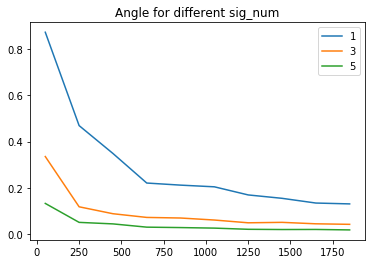

In [91]:
plt.figure()
plt.plot(ens_array, angle_array)
plt.plot(ens_array, angle_array2)
plt.plot(ens_array, angle_array3)
plt.title(f'Angle for different sig_num')
plt.legend(['1', '3', '5'])

In [92]:
sig_num = 3
V_true = VT[1:sig_num].T
mu = np.zeros(dimension)
angle_array4 = ens_array * np.nan
for count, ens_size in enumerate(ens_array):
    dist = np.ones(iter_num) * np.nan
    for num in range(iter_num):
        ensemble = assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt'])
        P_sample = np.cov(ensemble)
        this_trans_mats = assimilate.transformation_matrices(
            H, P=P_sample,
            R=R, return_Ts=False)
        this_V = this_trans_mats['VT'][1:sig_num].T
        dist[num] = angle_2(V_true, this_V)
    angle_array4[count] = dist.mean()
    print(f'ens_size: {ens_size} ; angle: {angle_array4[count]}')

ens_size: 50 ; angle: 0.5533740594522782
ens_size: 250 ; angle: 0.34545630494327934
ens_size: 450 ; angle: 0.26707131832185194
ens_size: 650 ; angle: 0.1792349778513975
ens_size: 850 ; angle: 0.1597470073147293
ens_size: 1050 ; angle: 0.1626366843904337
ens_size: 1250 ; angle: 0.11002067525731388
ens_size: 1450 ; angle: 0.11046548922452396
ens_size: 1650 ; angle: 0.09586474335681713
ens_size: 1850 ; angle: 0.08336095299746521


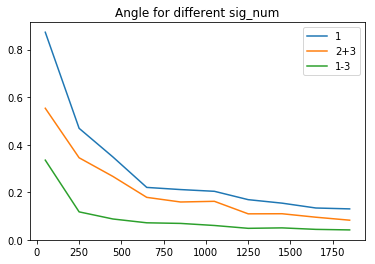

In [94]:
plt.figure()
plt.plot(ens_array, angle_array)
plt.plot(ens_array, angle_array4)
plt.plot(ens_array, angle_array2)
plt.title(f'Angle for different sig_num')
plt.legend(['1', '2+3', '1-3'])